# EXTRACTION DE KEYWORDS POUR L'AMOUR ATYPIQUE
### Corpus CAMille - Presse belge francophone (1831-1993)


## Imports

In [25]:
import os
import re 
import yake
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import spacy
from collections import defaultdict


In [26]:
# --- CONFIGURATION ---
data_path = "../../data/txt_tp4"  # Chemin vers vos fichiers .txt
output_csv = "../../data/results/keywords_sorcieres_1951_1993.csv"
output_plot = "../../data/results/evolution_sorcieres_1951_1993.png"

In [27]:
# --- MOTS-CIBLES ÉTENDUS (STRUCTURÉS PAR THÈMES) ---
mots_cibles = {
    "sorcière": ["sorcières", "sorcellerie", "sorcier", "sorciers", "magie noire", "magie blanche",
                 "envoûtement", "envoûteuse", "sortilège", "maléfice", "pouvoirs occultes",
                 "pacte diabolique", "sabbat", "vol nocturne", "grimoire", "rituel magique",
                 "incantation", "potion", "chaudron", "balai", "familier", "démonologie",
                 "macrale", "tchestia", "djinn", "vaudou", "chamanisme", "nécromancie"],
    "féminin": ["femme", "femmes", "féminin", "féminité", "féminisme", "féministes", "MLF",
                "sœur", "mère", "grand-mère", "vieille femme", "veuve", "célibataire",
                "sage-femme", "guérisseuse", "herboriste", "accoucheuse", "matriarcat",
                "sororité", "émancipation", "autonomie féminine", "pouvoir des femmes",
                "libération féminine", "witch feminism", "sorcière féministe",
                "réappropriation", "symbole féminin", "déesse", "triple déesse"],
    "religion": ["diable", "démon", "satan", "lucifer", "belzébuth", "possédé", "exorcisme",
                 "église", "catholique", "prêtre", "curé", "confession", "péché", "hérésie",
                 "inquisition", "condamnation religieuse", "malédiction", "sainte", "vierge",
                 "miracle", "superstition", "culte païen", "sabbath", "messire",
                 "excommunication", "rituel satanique", "culte du diable", "pacte avec le malin"],
    "justice": ["procès", "tribunal", "jugement", "accusation", "torture", "bûcher", "exécution",
                "châtiment", "loi", "code pénal", "dénonciation", "victime", "innocente",
                "culpable", "preuve", "aveu forcé", "chasse aux sorcières", "inquisiteur",
                "bourreau", "autodafé", "condamnation", "peine de mort", "tribunal ecclésiastique",
                "question"],
    "folklore": ["légende", "mythe", "conte", "tradition populaire", "croyance", "superstition",
                 "potion", "incantation", "macrale", "tchestia", "loup-garou", "fée", "lutin",
                 "esprit", "revenant", "spectre", "fantôme", "chaman", "druide", "alchimie",
                 "astrologie", "cartomancie", "chiromancie", "nécromancie", "vaudou"],
    "stigmate": ["marginale", "rejet", "exclusion", "tabou", "interdit", "immoral", "déviant",
                 "bizarre", "folie", "hystérie", "démoniaque", "possédée", "maléfique", "maudite",
                 "honte", "scandale", "déshonneur", "infâme", "monstrueuse", "anormale",
                 "dangereuse", "subversive", "réprouvée", "excommuniée", "hérétique", "soupçonnée"],
    "exclusions": ["fémur", "parfum", "mode", "jeu", "enfant", "jouet", "déguisement", "fête",
                   "carnaval", "maquillage", "chic", "élégant", "coquet", "recette", "cuisine",
                   "météorologie", "tempête", "orage", "film", "cinéma", "théâtre", "costume",
                   "décor", "scène", "roman", "livre", "bd", "dessins animés", "série", "feuilleton",
                   "fiction", "personnage"]
}


In [28]:
# Initialisation de YAKE (extraction de keywords)
kw_extractor = yake.KeywordExtractor(
    lan="fr",
    n=3,
    dedupLim=0.7,
    dedupFunc='seqm',
    windowsSize=1,
    top=200,
    stopwords=None  # Pour ne pas exclure "femme", "magie", etc.
)


In [29]:
def nettoyer_texte(text):
    """Nettoyage adapté aux textes historiques (OCR + accents)."""
    text = re.sub(r'[^\w\s\'\-àâäéèêëîïôöùûüç]', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(
        r'\b([A-Z]{2,}|hmu|xii|xix|xxe|xxx|pp?\.\s?\d+|le\soir|bruxelles|belge|franc)\b',
        '', text, flags=re.IGNORECASE
    )
    return text

def extraire_keywords_yake(text, top_n=10):
    """Extraction de keywords avec YAKE + filtrage par mots-cibles."""
    text_nettoye = nettoyer_texte(text)
    keywords_yake = kw_extractor.extract_keywords(text_nettoye)

    keywords_filtres = []
    for kw, score in keywords_yake:
        kw_lower = kw.lower()
        score_final = float(score)

        # Boost ou exclusion
        for categorie, mots in mots_cibles.items():
            if categorie != "exclusions" and any(mot in kw_lower for mot in mots):
                score_final *= 1.5
                break
            elif categorie == "exclusions" and any(mot in kw_lower for mot in mots):
                score_final = 0
                break

        # Garde uniquement les keywords pertinents
        if score_final > 0 and len(kw.split()) >= 1 and len(kw) > 3 and not any(c.isdigit() for c in kw):
            keywords_filtres.append((kw, score_final))

    return sorted(keywords_filtres, key=lambda x: x[1], reverse=True)[:top_n]


In [30]:
def analyser_corpus(data_path):
    """Analyse tous les fichiers .txt dans le dossier spécifié."""
    results = []
    for fichier in tqdm(os.listdir(data_path), desc="Analyse des fichiers"):
        if fichier.endswith(".txt"):
            with open(os.path.join(data_path, fichier), 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()
                date_match = re.search(r'(\d{4}-\d{2}-\d{2})', fichier)
                date = date_match.group(1) if date_match else "1900-01-01"

                keywords = extraire_keywords_yake(text)
                if keywords:
                    results.append({
                        "fichier": fichier,
                        "date": date,
                        "top_keywords": keywords
                    })
    return results


🔍 Début de l'analyse du corpus...


Analyse des fichiers: 100%|██████████| 999/999 [55:51<00:00,  3.35s/it]  
/var/folders/8p/3_0bn8l51lbc8zvsvbpm93wr0000gn/T/ipykernel_20124/3469522579.py:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.set_index('date').resample('5Y').size().plot(


 Export CSV terminé (999 entrées) → ../../data/results/keywords_sorcieres_1951_1993.csv


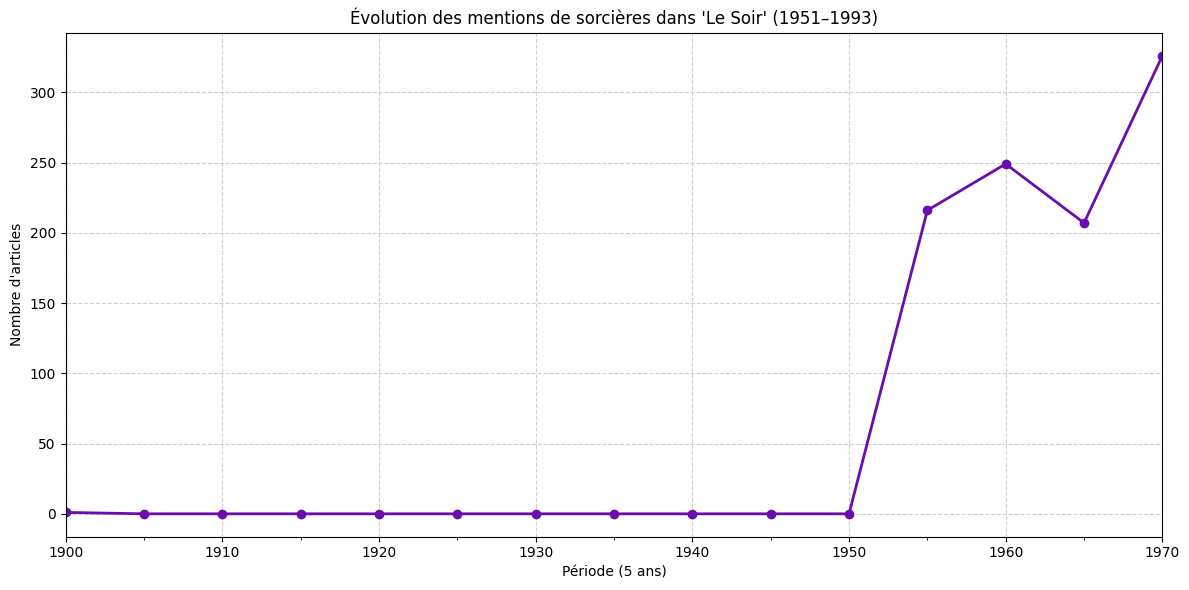

 Graphique sauvegardé → ../../data/results/evolution_sorcieres_1951_1993.png


In [31]:
if __name__ == "__main__":
    print("🔍 Début de l'analyse du corpus...")
    results = analyser_corpus(data_path)

    # Export CSV
    df = pd.DataFrame([
        {
            "fichier": r["fichier"],
            "date": r["date"],
            "keywords": "; ".join([f"{kw[0]} ({kw[1]:.4f})" for kw in r["top_keywords"]])
        }
        for r in results
    ])
    df.to_csv(output_csv, index=False, encoding='utf-8-sig', sep=';')
    print(f" Export CSV terminé ({len(df)} entrées) → {output_csv}")

    # Visualisation (si assez de données)
    if len(df) > 10:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date'])
        if len(df) > 1:
            plt.figure(figsize=(12, 6))
            df.set_index('date').resample('5Y').size().plot(
                kind='line',
                marker='o',
                color='#6a0dad',
                linewidth=2,
                title="Évolution des mentions de sorcières dans 'Le Soir' (1951–1993)",
                xlabel="Période (5 ans)",
                ylabel="Nombre d'articles"
            )
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.savefig(output_plot, dpi=300, bbox_inches='tight')
            plt.show()
            print(f" Graphique sauvegardé → {output_plot}")
        else:
            print(" Pas assez de données pour générer un graphique fiable.")
    else:
        print(" Aucun résultat pertinent trouvé. Vérifiez les chemins ou ajustez les mots-cibles.")
